<a href="https://colab.research.google.com/github/michellehkim280/project_voting/blob/main/VotingProject3ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! git clone https://github.com/carascott/project_voting

Cloning into 'project_voting'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 63 (delta 3), reused 3 (delta 3), pack-reused 56
Receiving objects: 100% (63/63), 31.36 MiB | 13.30 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [ ]:
pip install mapclassify

In [30]:
import geopandas as gpd
# import mapclassify
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable
import zipfile
import os

#gdf = '/content/sample_data/Virginia_AdministrativeBoundary.zip'

#with zipfile.ZipFile(gdf, 'r') as zip_ref:
    #zip_ref.extractall('extracted_contents_directory')

# gdf = gpd.read_file('/content/sample_data/Virginia_AdministrativeBoundary.zip') # Load Virginia shapefile for maps
vdf = pd.read_csv('/content/project_voting/data/voting_VA.csv') # Load historical voting data
cdf = pd.read_csv('/content/project_voting/data/county_adjacencies.csv') # Load county adjacency data and population data

# Merge shapefile data and county adjacency data:
#gdf['FIPS_left'] = pd.to_numeric(gdf['STCOFIPS'])
#df = gdf.merge(cdf,left_on='FIPS_left',right_on='FIPS')  # merge county population and adjacency data into df
#del gdf, cdf

In [40]:
print(cdf)

               County  Population2022   FIPS  District                   N1  \
0            Accomack           33191  51001         2       Northumberland   
1           Albemarle          114534  51003         5  CharlottesvilleCity   
2      AlexandriaCity          155525  51510         8              Fairfax   
3           Alleghany           14835  51005         6                Craig   
4              Amelia           13455  51007         5         PrinceEdward   
..                ...             ...    ...       ...                  ...   
128    WinchesterCity           27936  51840         6            Frederick   
129              Wise           35421  51195         9                  Lee   
130             Wythe           28111  51197         9                Bland   
131              York           71341  51199         1           Gloucester   
132  WilliamsburgCity           15920  51830         1             JamesCty   

             N2                N3               N4 

In [21]:
# Cleaning vdf (historical voting data)
# Standardize FIPS codes to ensure they are five characters long, zero-padded
vdf['county_fips'] = vdf['county_fips'].astype(str).str.zfill(5)

# Remove any rows where critical information is missing
vdf.dropna(subset=['county_fips', 'candidatevotes', 'totalvotes'], inplace=True)

# Convert vote counts to integers (in case they are not)
vdf['candidatevotes'] = vdf['candidatevotes'].astype(int)
vdf['totalvotes'] = vdf['totalvotes'].astype(int)

# Check for any duplicates and remove them
vdf.drop_duplicates(inplace=True)

# Convert certain columns with usable data to lower case for ease
vdf['county_name'] = vdf['county_name'].str.lower()
vdf['candidate'] = vdf['candidate'].str.lower()
vdf['party'] = vdf['party'].str.lower()

# Save cleaned data
#vdf.to_csv('/content/project_voting/data/aaaaaaa.csv', index=False)

In [39]:
print(vdf)

      Unnamed: 0  year     state state_po      county_name  county_fips  \
0          11161  2000  VIRGINIA       VA         ACCOMACK        51001   
1          11162  2000  VIRGINIA       VA         ACCOMACK        51001   
2          11163  2000  VIRGINIA       VA         ACCOMACK        51001   
3          11164  2000  VIRGINIA       VA         ACCOMACK        51001   
4          11165  2000  VIRGINIA       VA        ALBEMARLE        51003   
...          ...   ...       ...      ...              ...          ...   
3731       71966  2020  VIRGINIA       VA  WINCHESTER CITY        51840   
3732       71967  2020  VIRGINIA       VA  WINCHESTER CITY        51840   
3733       71968  2020  VIRGINIA       VA  WINCHESTER CITY        51840   
3734       71969  2020  VIRGINIA       VA  WINCHESTER CITY        51840   
3735       71970  2020  VIRGINIA       VA  WINCHESTER CITY        51840   

            office       candidate       party  candidatevotes  totalvotes  \
0     US PRESIDENT   

In [37]:
# Cleaning/loading VA shapefile

def load_data(file_path):
    return pd.read_csv(file_path, encoding='ISO-8859-1', low_memory=False)

def prepare_data(df):
    # Standardize FIPS codes
    fips_columns = [col for col in ['FIPS', 'county_fips'] if col in df.columns]
    for col in fips_columns:
        df[col] = df[col].astype(str).str.zfill(5)

    # Remove unnecessary columns
    columns_to_drop = [col for col in ['Unneeded1', 'Unneeded2'] if col in df.columns]
    df.drop(columns=columns_to_drop, inplace=True)

    # Fill numeric columns with the median
    for col in df.select_dtypes(include='number').columns:
        df[col].fillna(df[col].median(), inplace=True)

    # Fill categorical columns with the mode (most frequent value)
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype(str)
        if not df[col].mode().empty:
            df[col].fillna(df[col].mode()[0], inplace=True)

    # Remove rows with missing FIPS codes if critical
    df.dropna(subset=fips_columns, inplace=True)

    # Remove duplicates
    df.drop_duplicates(inplace=True)

    return df

# Directory to save cleaned files
output_directory = '/content/project_voting/data'
os.makedirs(output_directory, exist_ok=True)

# Paths to the county data files
files = [
    '/content/project_voting/data/0002_ds176_20105_county_E.csv',
    '/content/project_voting/data/0002_ds177_20105_county_E.csv',
    '/content/project_voting/data/0002_ds191_20125_county_E.csv',
    '/content/project_voting/data/0002_ds206_20145_county_E.csv',
    '/content/project_voting/data/0002_ds225_20165_county_E.csv',
    '/content/project_voting/data/0002_ds239_20185_county_E.csv',
    '/content/project_voting/data/0002_ds249_20205_county_E.csv',
    '/content/project_voting/data/0002_ds250_20205_county_E.csv'
]

# Load, clean, and save each file
for file_path in files:
    df = load_data(file_path)
    gdf = prepare_data(df)
    cleaned_file_path = os.path.join(output_directory, os.path.basename(file_path).replace('.csv', '_cleaned.csv'))
    gdf.to_csv(cleaned_file_path, index=False)
print(gdf)

      Unnamed: 0              GISJOIN            YEAR  \
0              1  GIS Join Match Code  Data File Year   
1              2             G0100010       2016-2020   
2              3             G0100030       2016-2020   
3              4             G0100050       2016-2020   
4              5             G0100070       2016-2020   
...          ...                  ...             ...   
3217        3218             G7201450       2016-2020   
3218        3219             G7201470       2016-2020   
3219        3220             G7201490       2016-2020   
3220        3221             G7201510       2016-2020   
3221        3222             G7201530       2016-2020   

                         STUSAB      REGIONA      DIVISIONA        STATE  \
0     State Postal Abbreviation  Region Code  Division Code   State Name   
1                            AL          nan            nan      Alabama   
2                            AL          nan            nan      Alabama   
3          

In [41]:
df = pd.merge(vdf, cdf, left_on='county_fips', right_on='FIPS', how='inner')
print(df)

      Unnamed: 0  year     state state_po      county_name  county_fips  \
0          11161  2000  VIRGINIA       VA         ACCOMACK        51001   
1          11162  2000  VIRGINIA       VA         ACCOMACK        51001   
2          11163  2000  VIRGINIA       VA         ACCOMACK        51001   
3          11164  2000  VIRGINIA       VA         ACCOMACK        51001   
4          20838  2004  VIRGINIA       VA         ACCOMACK        51001   
...          ...   ...       ...      ...              ...          ...   
3715       71966  2020  VIRGINIA       VA  WINCHESTER CITY        51840   
3716       71967  2020  VIRGINIA       VA  WINCHESTER CITY        51840   
3717       71968  2020  VIRGINIA       VA  WINCHESTER CITY        51840   
3718       71969  2020  VIRGINIA       VA  WINCHESTER CITY        51840   
3719       71970  2020  VIRGINIA       VA  WINCHESTER CITY        51840   

            office       candidate       party  candidatevotes  ...  \
0     US PRESIDENT         A

In [38]:
# Merge shapefile data and county adjacency data:
gdf['FIPS_left'] = pd.to_numeric(gdf['STCOFIPS'])
df = gdf.merge(cdf,left_on='FIPS_left',right_on='FIPS')  # merge county population and adjacency data into df
del gdf, cdf

KeyError: 'STCOFIPS'

In [8]:
#for column_name in vdf.columns.tolist():
    #print(column_name)
#year (NUM)
#state
#state_po
#county_name
#county_fips (NUM)
#office
#candidate
#party
#candidatevotes (NUM)
#totalvotes (NUM)
#version (NUM)
#mode
#for column_name in cdf.columns.tolist():
    #print(column_name)
#County
#Population2022 (NUM)
#FIPS (NUM)
#District (NUM)
#N1
#N2
#N3
#N4
#N5
#N6
#N7
#N8
#N9
#N10
#N11
#N12

In [36]:
vdf.head()

,Unnamed: 0,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode,candidate_numeric
0,11161,2000,VIRGINIA,VA,accomack,51001,US PRESIDENT,al gore,democrat,5092,11925,20220315,TOTAL,0
1,11162,2000,VIRGINIA,VA,accomack,51001,US PRESIDENT,george w. bush,republican,6352,11925,20220315,TOTAL,1
2,11163,2000,VIRGINIA,VA,accomack,51001,US PRESIDENT,ralph nader,green,220,11925,20220315,TOTAL,2
3,11164,2000,VIRGINIA,VA,accomack,51001,US PRESIDENT,other,other,261,11925,20220315,TOTAL,3
4,11165,2000,VIRGINIA,VA,albemarle,51003,US PRESIDENT,al gore,democrat,16255,36846,20220315,TOTAL,0


In [9]:
vdf_filtered = vdf[['candidate', 'party', 'candidatevotes', 'year', 'county_name']]

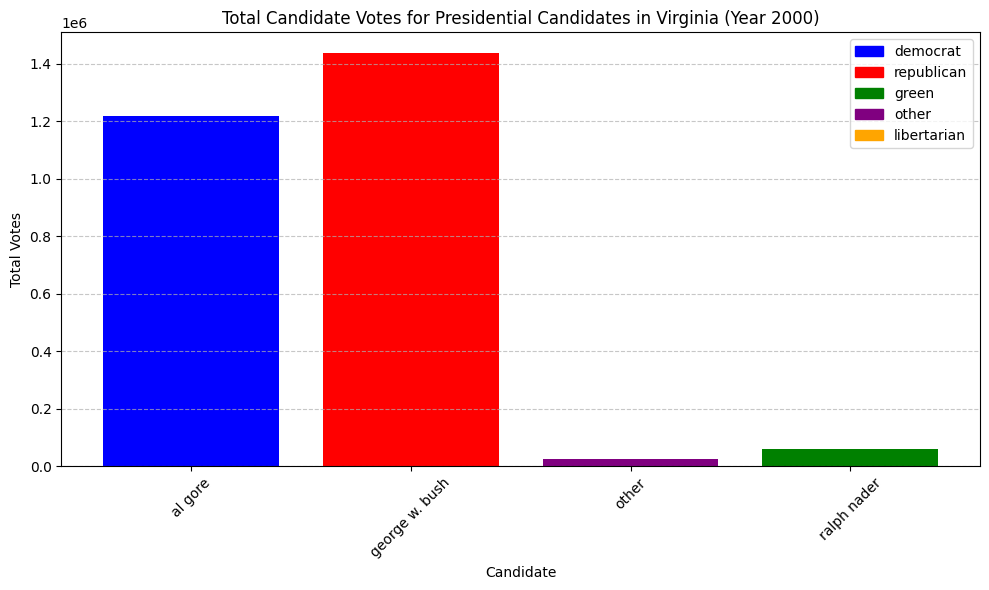

In [10]:
# 2000: Filter the DataFrame for the election year
vdf_2000 = vdf_filtered[vdf_filtered['year'] == 2000]
total_candidate_votes = vdf_2000.groupby('candidate')['candidatevotes'].sum()
#print(total_candidate_votes)
#print(vdf_2000)

color_map = {
    'democrat': 'blue',
    'republican': 'red',
    'green': 'green',
    'other': 'purple',
    'libertarian': 'orange'
}

plt.figure(figsize=(10, 6))
for candidate, votes in total_candidate_votes.items():
    party_color = color_map[vdf[vdf['candidate'] == candidate]['party'].iloc[0]]
    plt.bar(candidate, votes, color=party_color)
legend_labels = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(legend_labels, color_map.keys(), loc='upper right')
plt.title('Total Candidate Votes for Presidential Candidates in Virginia (Year 2000)')
plt.xlabel('Candidate')
plt.ylabel('Total Votes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

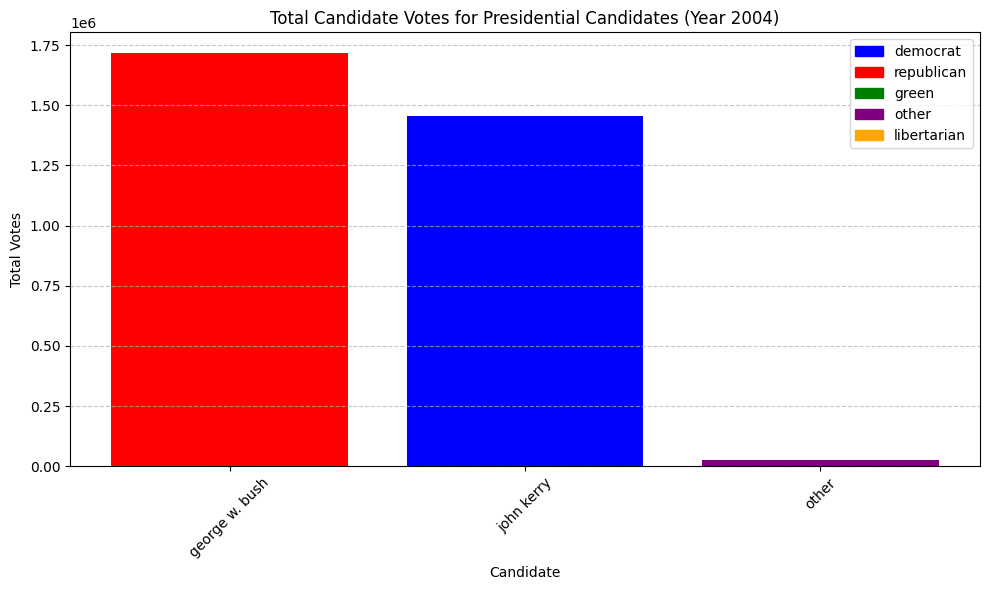

In [80]:
# 2004: Filter the DataFrame for the election year
vdf_2004 = vdf_filtered[vdf_filtered['year'] == 2004]
total_candidate_votes = vdf_2004.groupby('candidate')['candidatevotes'].sum()

color_map = {
    'democrat': 'blue',
    'republican': 'red',
    'green': 'green',
    'other': 'purple',
    'libertarian': 'orange'
}

plt.figure(figsize=(10, 6))
for candidate, votes in total_candidate_votes.items():
    party_color = color_map[vdf[vdf['candidate'] == candidate]['party'].iloc[0]]
    plt.bar(candidate, votes, color=party_color)
legend_labels = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(legend_labels, color_map.keys(), loc='upper right')
plt.title('Total Candidate Votes for Presidential Candidates in Virginia (Year 2004)')
plt.xlabel('Candidate')
plt.ylabel('Total Votes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

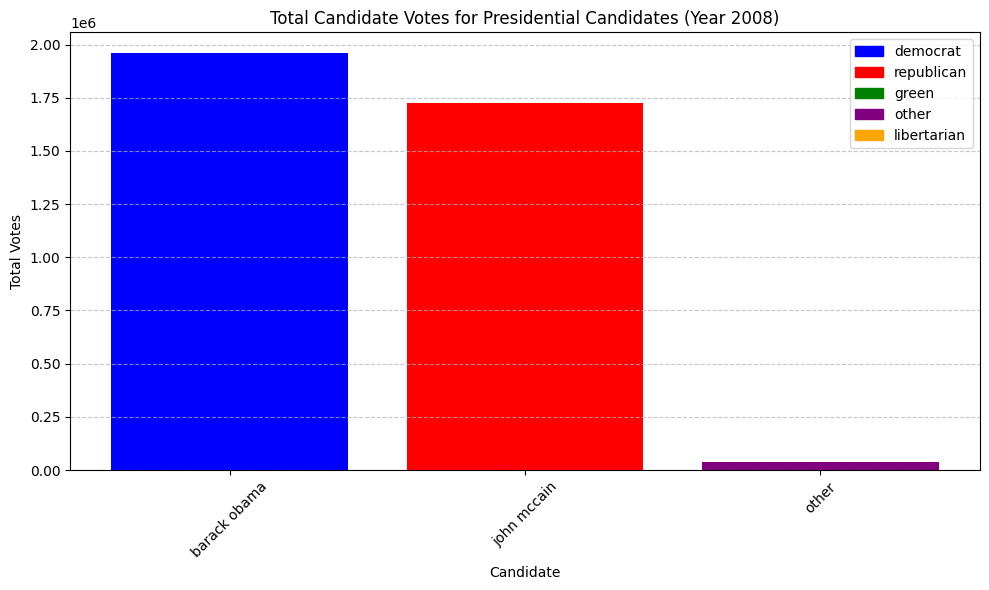

In [81]:
# 2008: Filter the DataFrame for the election year
vdf_2008 = vdf_filtered[vdf_filtered['year'] == 2008]
total_candidate_votes = vdf_2008.groupby('candidate')['candidatevotes'].sum()

color_map = {
    'democrat': 'blue',
    'republican': 'red',
    'green': 'green',
    'other': 'purple',
    'libertarian': 'orange'
}

plt.figure(figsize=(10, 6))
for candidate, votes in total_candidate_votes.items():
    party_color = color_map[vdf[vdf['candidate'] == candidate]['party'].iloc[0]]
    plt.bar(candidate, votes, color=party_color)
legend_labels = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(legend_labels, color_map.keys(), loc='upper right')
plt.title('Total Candidate Votes for Presidential Candidates in Virginia (Year 2008)')
plt.xlabel('Candidate')
plt.ylabel('Total Votes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

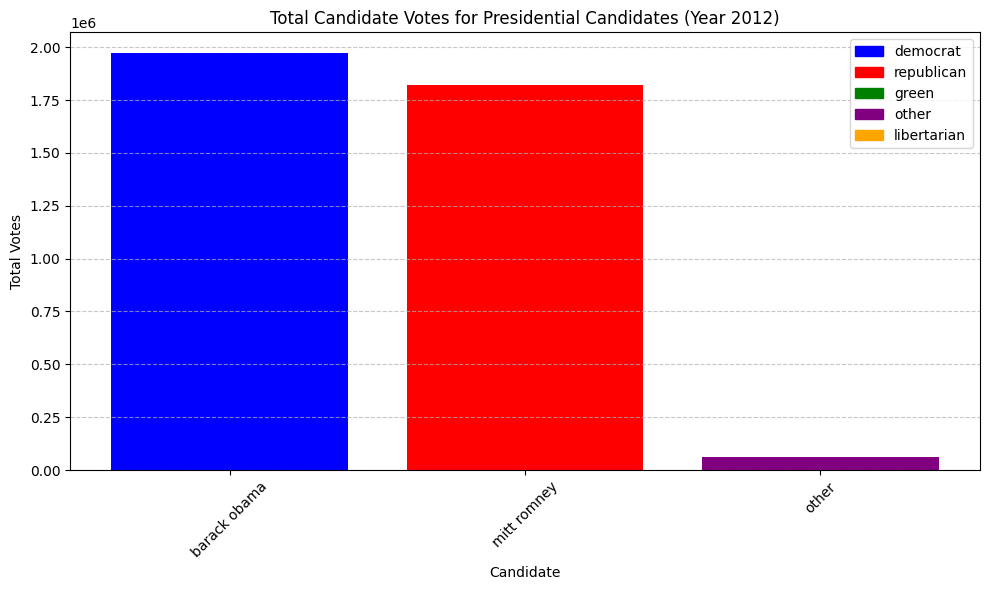

In [83]:
# 2012: Filter the DataFrame for the election year
vdf_2012 = vdf_filtered[vdf_filtered['year'] == 2012]
total_candidate_votes = vdf_2012.groupby('candidate')['candidatevotes'].sum()

color_map = {
    'democrat': 'blue',
    'republican': 'red',
    'green': 'green',
    'other': 'purple',
    'libertarian': 'orange'
}

plt.figure(figsize=(10, 6))
for candidate, votes in total_candidate_votes.items():
    party_color = color_map[vdf[vdf['candidate'] == candidate]['party'].iloc[0]]
    plt.bar(candidate, votes, color=party_color)
legend_labels = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(legend_labels, color_map.keys(), loc='upper right')
plt.title('Total Candidate Votes for Presidential Candidates in Virginia (Year 2012)')
plt.xlabel('Candidate')
plt.ylabel('Total Votes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

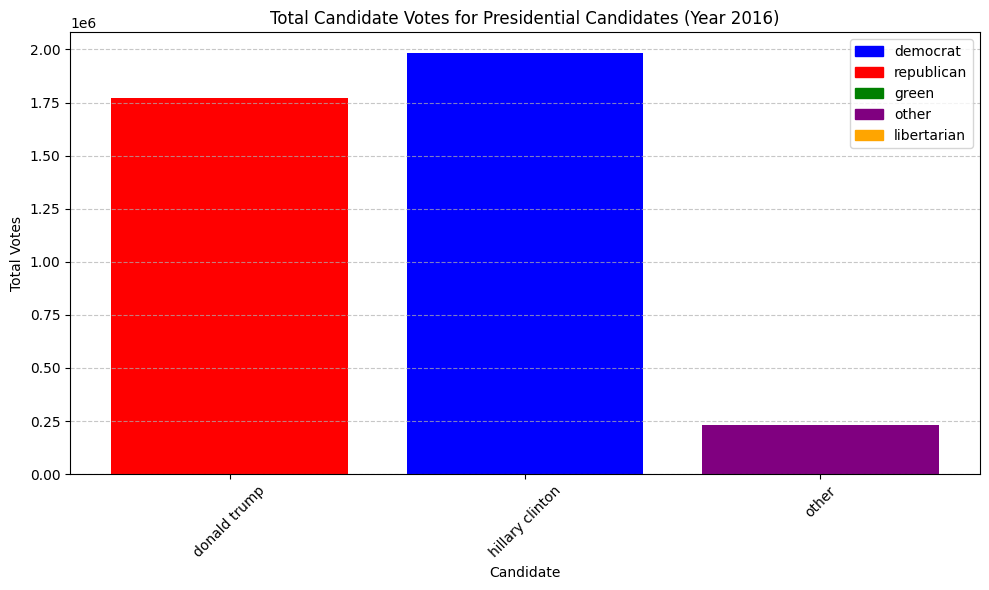

In [84]:
# 2016: Filter the DataFrame for the election year
vdf_2016 = vdf_filtered[vdf_filtered['year'] == 2016]
total_candidate_votes = vdf_2016.groupby('candidate')['candidatevotes'].sum()

color_map = {
    'democrat': 'blue',
    'republican': 'red',
    'green': 'green',
    'other': 'purple',
    'libertarian': 'orange'
}

plt.figure(figsize=(10, 6))
for candidate, votes in total_candidate_votes.items():
    party_color = color_map[vdf[vdf['candidate'] == candidate]['party'].iloc[0]]
    plt.bar(candidate, votes, color=party_color)
legend_labels = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(legend_labels, color_map.keys(), loc='upper right')
plt.title('Total Candidate Votes for Presidential Candidates in Virginia (Year 2016)')
plt.xlabel('Candidate')
plt.ylabel('Total Votes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

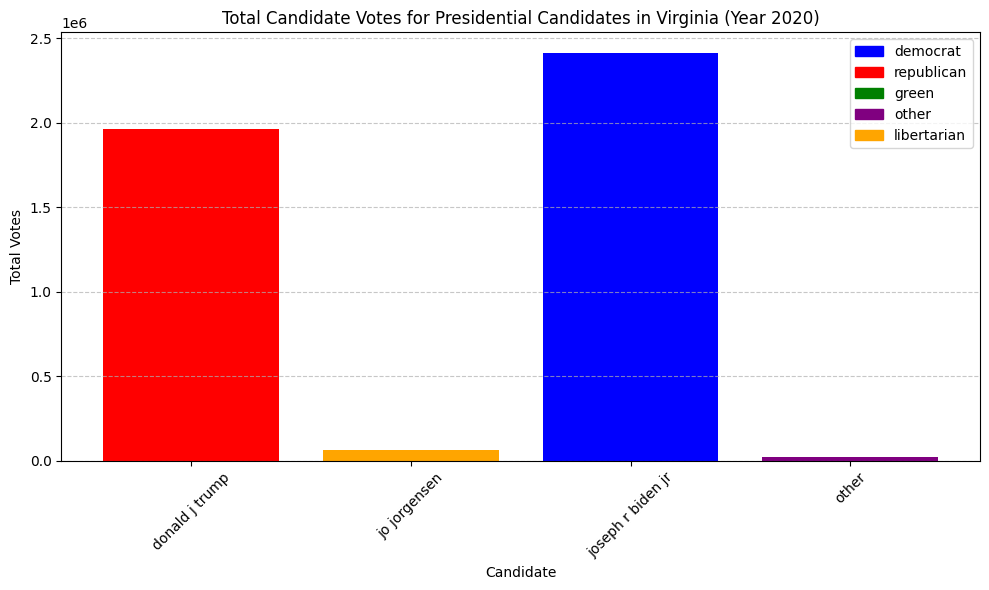

In [11]:
# 2020: Filter the DataFrame for the election year
vdf_2020 = vdf_filtered[vdf_filtered['year'] == 2020]
total_candidate_votes = vdf_2020.groupby('candidate')['candidatevotes'].sum()

color_map = {
    'democrat': 'blue',
    'republican': 'red',
    'green': 'green',
    'other': 'purple',
    'libertarian': 'orange'
}

plt.figure(figsize=(10, 6))
for candidate, votes in total_candidate_votes.items():
    party_color = color_map[vdf[vdf['candidate'] == candidate]['party'].iloc[0]]
    plt.bar(candidate, votes, color=party_color)
legend_labels = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(legend_labels, color_map.keys(), loc='upper right')
plt.title('Total Candidate Votes for Presidential Candidates in Virginia (Year 2020)')
plt.xlabel('Candidate')
plt.ylabel('Total Votes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<ipython-input-12-742707595a6e>:12: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=albemarledf, x='year', y='candidatevotes', hue="party", palette=party_colors, fill=True)


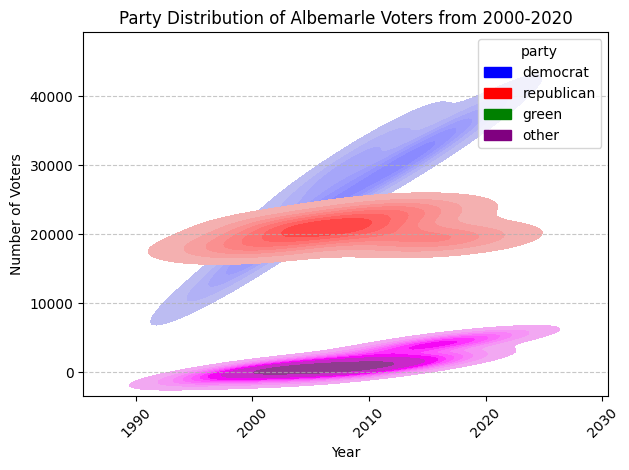

In [12]:
# Showing party distribution of Albemarle voters over time
albemarledf = vdf_filtered[(vdf_filtered['county_name'] == 'albemarle') & (vdf_filtered['year'].isin(range(2000,2020)))]
#print(albemarledf)

party_colors = {
    'democrat': 'blue',
    'republican': 'red',
    'green': 'green',
    'other': 'purple',
    'libertarian': 'orange'
}
sns.kdeplot(data=albemarledf, x='year', y='candidatevotes', hue="party", palette=party_colors, fill=True)
plt.title('Party Distribution of Albemarle Voters from 2000-2020')
plt.xlabel("Year")
plt.ylabel("Number of Voters")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

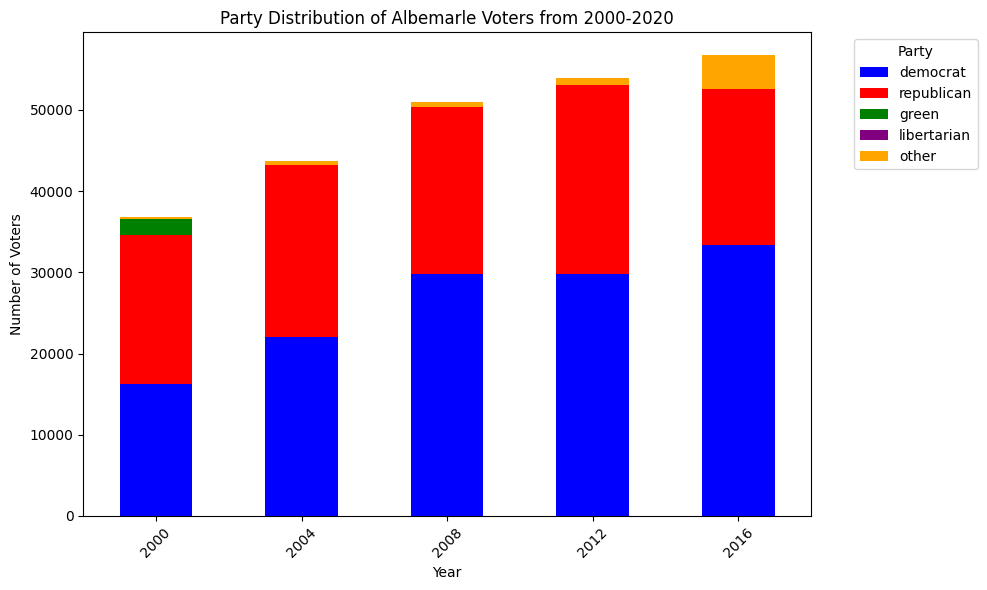

In [14]:
pivot_df = albemarledf.pivot_table(index='year', columns='party', values='candidatevotes', aggfunc='sum', fill_value=0)

column_order = ['democrat', 'republican', 'green', 'libertarian', 'other']
pivot_df = pivot_df.reindex(columns=column_order)

pivot_df.plot(kind='bar', stacked=True, color=party_colors.values(), figsize=(10, 6))

plt.title('Party Distribution of Albemarle Voters from 2000-2020')
plt.xlabel('Year')
plt.ylabel('Number of Voters')
plt.xticks(rotation=45)
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

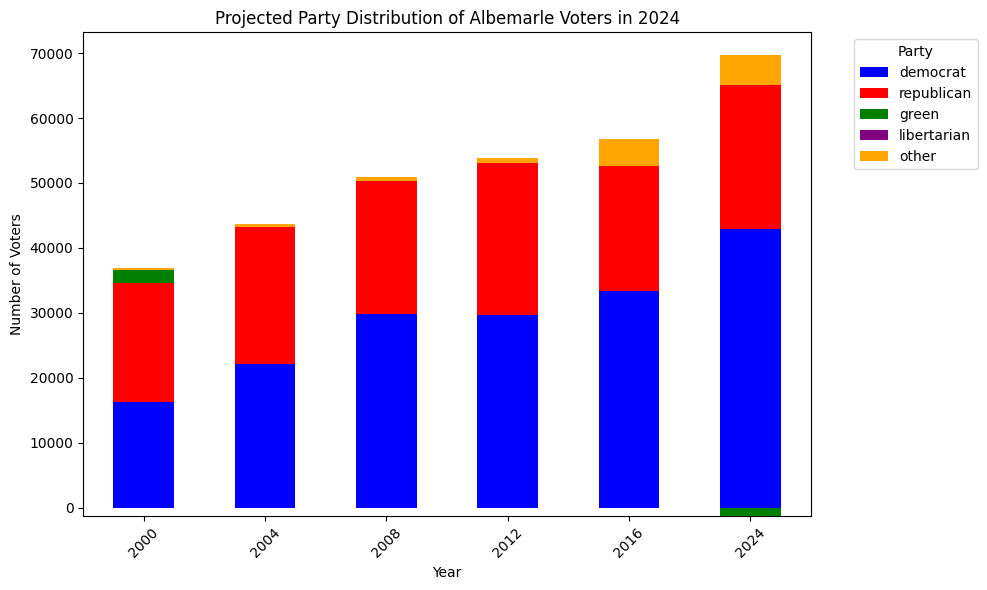

In [28]:
predictions = {}
for party in pivot_df.columns:
    X = pivot_df.index.values.reshape(-1, 1)
    y = pivot_df[party].values.reshape(-1, 1)

    # Check for missing values in y
    if np.isnan(y).any():
        print(f"Warning: Missing values detected for party '{party}'. Skipping prediction.")
        continue

    model = LinearRegression()
    model.fit(X, y)
    predictions[party] = model.predict([[2024]])[0][0]

# Adding 2024 predictions to the DataFrame
prediction_df = pd.DataFrame(predictions, index=[2024])

# Concatenate with the original DataFrame
pivot_df_with_predictions = pd.concat([pivot_df, prediction_df])

# Plotting stacked bar chart with predictions
pivot_df_with_predictions.plot(kind='bar', stacked=True, color=list(party_colors.values()) + ['pink'], figsize=(10, 6))

plt.title('Projected Party Distribution of Albemarle Voters in 2024')
plt.xlabel('Year')
plt.ylabel('Number of Voters')
plt.xticks(rotation=45)
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [17]:
vdf_y = vdf[vdf['year'] == 2012]
candidate_counts = vdf_y['candidate'].value_counts()
print("Number of votes for each candidate in the year 2000:")
print(candidate_counts)

Number of votes for each candidate in the year 2000:
candidate
barack obama    134
mitt romney     134
other           134
Name: count, dtype: int64


In [30]:
unique_responses = vdf_y['year'].value_counts()
print(unique_responses)
na_count = vdf_y['year'].isna().sum()
print(f"Number of NAs: {na_count}")

year
2000    536
Name: count, dtype: int64
Number of NAs: 0


In [ ]:
# Cleaning county_data

def load_data(file_path):
    return pd.read_csv(file_path, encoding='ISO-8859-1')

def prepare_data(df):
    # Standardize FIPS codes
    fips_columns = [col for col in ['FIPS', 'county_fips'] if col in df.columns]
    for col in fips_columns:
        df[col] = df[col].astype(str).str.zfill(5)

    # Remove unnecessary columns
    columns_to_drop = [col for col in ['Unneeded1', 'Unneeded2'] if col in df.columns]
    df.drop(columns=columns_to_drop, inplace=True)

    # Fill numeric columns with the median
    for col in df.select_dtypes(include='number').columns:
        df[col].fillna(df[col].median(), inplace=True)

    # Fill categorical columns with the mode (most frequent value)
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype(str)
        if not df[col].mode().empty:
            df[col].fillna(df[col].mode()[0], inplace=True)

    # Remove rows with missing FIPS codes if critical
    df.dropna(subset=fips_columns, inplace=True)

    # Remove duplicates
    df.drop_duplicates(inplace=True)

    return df

# Directory to save cleaned files
output_directory = '/content/project_voting/data/county_data/cleaned'
os.makedirs(output_directory, exist_ok=True)

# Paths to the county data files
files = [
    '/content/project_voting/data/county_data/0002_ds176_20105_county_E.csv',
    '/content/project_voting/data/county_data/0002_ds177_20105_county_E.csv',
    '/content/project_voting/data/county_data/0002_ds191_20125_county_E.csv',
    '/content/project_voting/data/county_data/0002_ds206_20145_county_E.csv',
    '/content/project_voting/data/county_data/0002_ds225_20165_county_E.csv',
    '/content/project_voting/data/county_data/0002_ds239_20185_county_E.csv',
    '/content/project_voting/data/county_data/0002_ds249_20205_county_E.csv',
    '/content/project_voting/data/county_data/0002_ds250_20205_county_E.csv'
]

# Load, clean, and save each file
for file_path in files:
    df = load_data(file_path)
    cleaned_df = prepare_data(df)
    cleaned_file_path = os.path.join(output_directory, os.path.basename(file_path).replace('.csv', '_cleaned.csv'))
    cleaned_df.to_csv(cleaned_file_path, index=False)
